In [1]:
!pip install torch
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
content_img = "/content/drive/MyDrive/Jatin/Neural_style_transfer/content"
style_img = "/content/drive/MyDrive/Jatin/Neural_style_transfer/style"

In [14]:
import torch
from torchvision import models

resnet = models.resnet50(weights=True)

resnet_layers = list(resnet.children())[:8]
resnet = torch.nn.Sequential(*resnet_layers)
for param in resnet.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [7]:
from PIL import Image
from torchvision import transforms as T
import torch
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def preprocess_image(image_path, max_size=500):
    image = Image.open(image_path).convert("RGB")
    size = max_size if max(image.size) > max_size else max(image.size)
    transform_pipeline = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform_pipeline(image).unsqueeze(0)
    return image

style_img_path = '/content/drive/MyDrive/Jatin/Neural_style_transfer/style/69561.jpg'
content_img_path = '/content/drive/MyDrive/Jatin/Neural_style_transfer/content/content10.jpg'
content_img = preprocess_image(content_img_path).to(device)
style_img = preprocess_image(style_img_path).to(device)

def inverse_image(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze(0).numpy().transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    return np.clip(image, 0, 1)

content_display = inverse_image(content_img)
style_display = inverse_image(style_img)

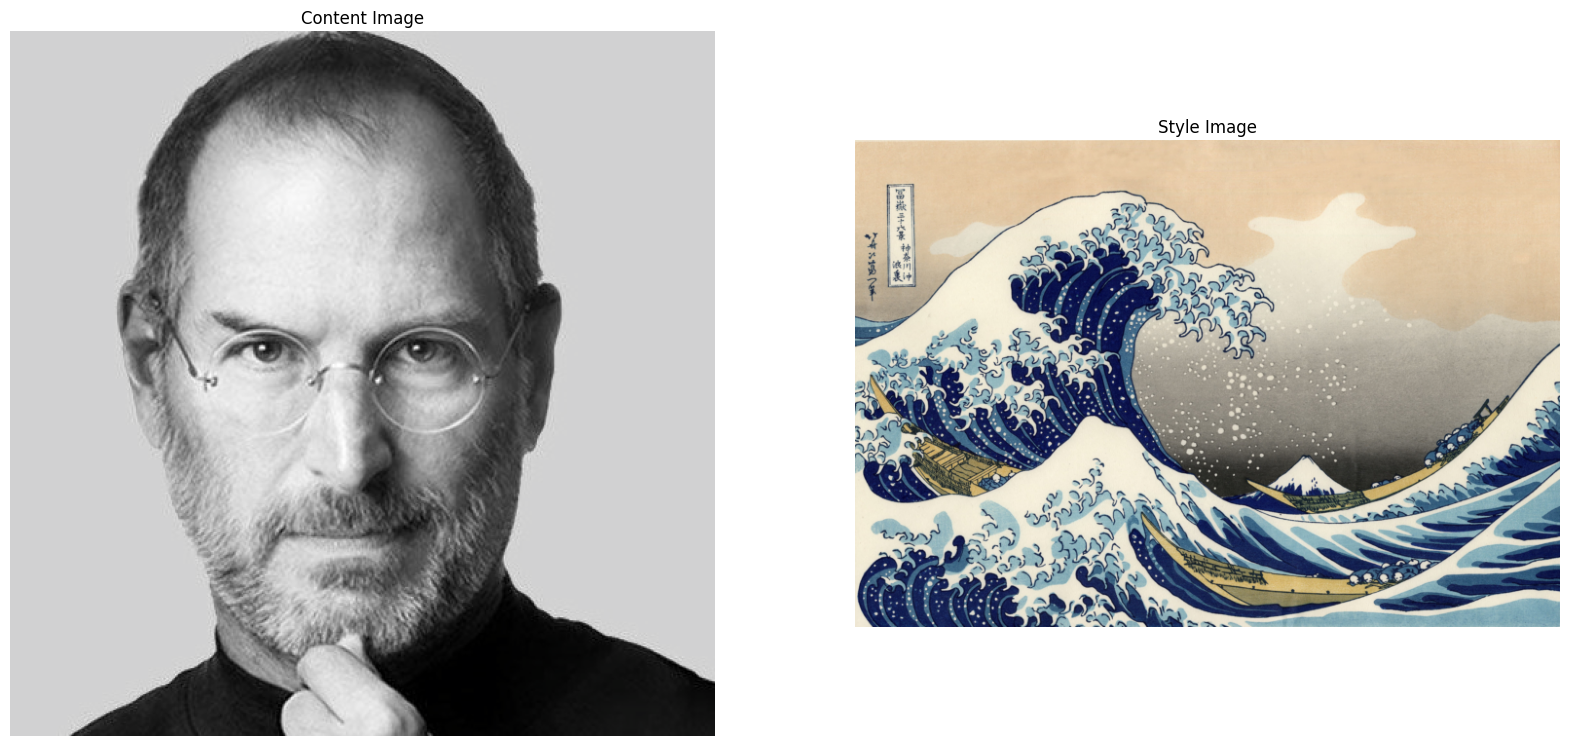

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(content_display)
ax1.axis('off')
ax1.set_title('Content Image')
ax2.imshow(style_display)
ax2.axis('off')
ax2.set_title('Style Image')
plt.show()

In [19]:
def extract_features(image, model):
    layers = {
        '0': 'conv1',
        '4': 'layer1',
        '5': 'layer2',
        '6': 'layer3',
        '7': 'layer4',
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

content_features = extract_features(content_img, resnet)
style_features = extract_features(style_img, resnet)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [21]:
def compute_content_loss(target, content):
    return torch.mean((target - content) ** 2)

style_layer_weights = {
    'conv1': 0.2,
    'layer1': 0.2,
    'layer2': 0.2,
    'layer3': 0.2,
    'layer4': 0.2,
}

def compute_style_loss(target_features, style_grams):
    loss = 0
    for layer in style_layer_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        b, c, h, w = target_feature.shape
        layer_loss = style_layer_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        loss += layer_loss
    return loss

target_image = content_img.clone().requires_grad_(True).to(device)

def compute_total_variation_loss(image):
    return torch.sum(torch.abs(image[:, :, :-1] - image[:, :, 1:])) + torch.sum(torch.abs(image[:, :-1, :] - image[:, 1:, :]))

def total_loss(c_loss, s_loss, tv_loss, alpha, beta, tv_weight):
    return alpha * c_loss + beta * s_loss + tv_weight * tv_loss

In [22]:
from torch import optim

optimizer = optim.AdamW([target_image], lr=3e-3)
alpha = 1
beta = 4
tv_weight = 1e-5

results = []

In [23]:
!pip install tqdm

In [24]:
from tqdm import tqdm
def train_style_transfer(target_image, content_features, style_grams, optimizer, alpha, beta, tv_weight, epochs = 5000, display_interval=1000):
    results = []

    #using tqdm to track progress
    for epoch in tqdm(range(epochs)):
        target_features = extract_features(target_image, resnet)
        content_loss_value = compute_content_loss(target_features['layer4'], content_features['layer4'])
        style_loss_value = compute_style_loss(target_features, style_grams)
        tv_loss_value = compute_total_variation_loss(target_image)
        total_loss_value = total_loss(content_loss_value, style_loss_value, tv_loss_value, alpha, beta, tv_weight)

        optimizer.zero_grad()
        total_loss_value.backward()
        optimizer.step()

        if epoch % display_interval == 0:
            results.append(inverse_image(target_image.detach()))
            tqdm.write(f"Loss after epoch {epoch}: {total_loss_value.item()}")

    return results

In [ ]:
from tqdm import tqdm
def train_style_transfer(target_image, content_features, style_grams, optimizer, alpha, beta, tv_weight, epochs = 5000, display_interval=1000):
    results = []

    #Using tqdm to track progress
    for epoch in tqdm(range(epochs)):
        target_features = extract_features(target_image, resnet)
        content_loss_value = compute_content_loss(target_features['layer4'], content_features['layer4'])
        style_loss_value = compute_style_loss(target_features, style_grams)
        tv_loss_value = compute_total_variation_loss(target_image)
        total_loss_value = total_loss(content_loss_value, style_loss_value, tv_loss_value, alpha, beta, tv_weight)

        optimizer.zero_grad()
        total_loss_value.backward()
        optimizer.step()

        if epoch % display_interval == 0:
            results.append(inverse_image(target_image.detach()))
            tqdm.write(f"Loss after epoch {epoch}: {total_loss_value.item()}")

    return results

results = train_style_transfer(target_image, content_features, style_grams, optimizer, alpha, beta, tv_weight)


  0%|          | 5/5000 [00:00<03:54, 21.33it/s]

Loss after epoch 0: 6210850816.0


 20%|██        | 1005/5000 [00:49<03:08, 21.16it/s]

Loss after epoch 1000: 6921866.5


 40%|████      | 2005/5000 [01:37<02:20, 21.37it/s]

Loss after epoch 2000: 1340868.875


 60%|██████    | 3006/5000 [02:26<01:35, 20.77it/s]

Loss after epoch 3000: 787051.625


 80%|████████  | 4006/5000 [03:15<00:46, 21.15it/s]

Loss after epoch 4000: 502208.03125


100%|██████████| 5000/5000 [04:03<00:00, 20.57it/s]


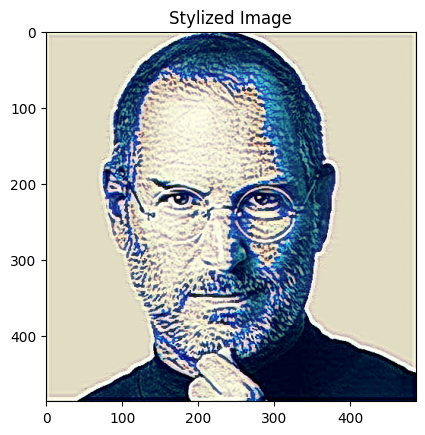

In [ ]:
#displaying the final stylized image
final_img = inverse_image(target_image.clone().detach())
plt.imshow(final_img)
plt.title('Stylized Image')
plt.show()

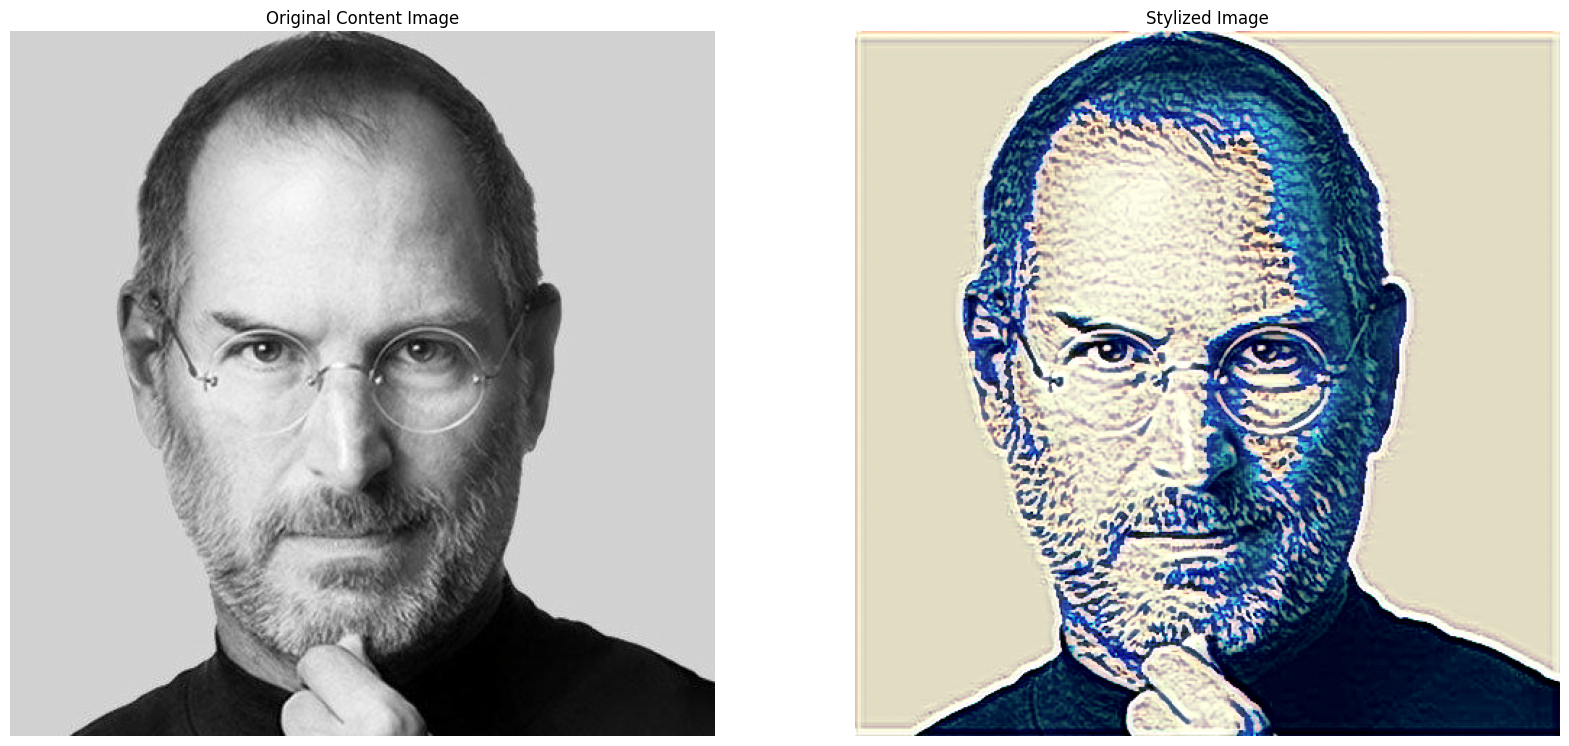

In [ ]:
#displaying the original content image and Final stylized image side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(content_display)
ax1.axis('off')
ax1.set_title('Original Content Image')

ax2.imshow(final_img)
ax2.axis('off')
ax2.set_title('Stylized Image')

plt.show()

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')